In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

from skimage import io

import numpy as np
import torch
import os
from PIL import Image, ImageOps, ImageFilter
import random

In [8]:
def data_generator(original_data_folder, augmented_data_folder, city, amount):
    
    path = os.path.join(original_data_folder, city)
    count = 0
    while count < amount:
        for imageFile in os.listdir(path):
            imagePath = os.path.join(path, imageFile).replace("\\", "/")

            # Transform image - slight rotations and 
            image = Image.open(imagePath)

            rand = random.randint(0,9)
            if rand <= 2:
                rand2= random.randint(-3,3)
                image = image.rotate(rand2)
            elif rand <= 5:
                image = ImageOps.grayscale(image)
            else:
                image = image.filter(ImageFilter.GaussianBlur(1))


            #Write Image to AugmentedData
            image.save(os.path.join(os.path.join(augmented_data_folder, city), str(count) + ".0,1.0.jpg").replace("\\", "/"))

            count += 1
            if count >= amount:
                break

In [11]:
imagePaths = []
start = time.time()
for city in os.listdir("./Data/"):
    path = os.path.join("./Data/", city)
    imagePaths.extend([os.path.join(path, imageFile).replace("\\", "/") for imageFile in os.listdir(path)])
    print(len(imagePaths))
    end = time.time()
    print(end-start)

13630
0.03176474571228027
40810
0.0903017520904541
49773
0.11294960975646973
72943
0.17197442054748535
123143
0.3007035255432129
128668
0.31372594833374023
157730
0.381664514541626
209412
0.502009391784668
214099
0.5139925479888916
222477
0.5343835353851318


In [15]:
balanced_size = 100000
dataParentFolder = "./Data/"
augmentedParentFolder = "./AugmentedData/"
class_balanced_size = int(balanced_size / 10)
start = time.time()
imagePaths = np.empty(balanced_size, dtype='object')
count = 0
for city in os.listdir(dataParentFolder):
    path = os.path.join(dataParentFolder, city)
    city_size = len(os.listdir(path))
    if city_size >= class_balanced_size:
        print("here")
        # Chop Data
        path_list = os.listdir(path)
        for i in range(class_balanced_size):
            imageFile = path_list[i]
            imagePaths[count] = os.path.join(path, imageFile).replace("\\", "/")
            count += 1
        end = time.time()
        print(end-start)
        print(class_balanced_size)
    else:
        print("here2")
        # First add original data
        path_list = os.listdir(path)
        for i in range(city_size):
            imageFile = path_list[i]
            imagePaths[count] = os.path.join(path, imageFile).replace("\\", "/")
            count += 1 

        # Generate new data
        augmented_path = os.path.join(augmentedParentFolder, city)
        if len(os.listdir(augmented_path)) < class_balanced_size - city_size:
            data_generator(dataParentFolder, augmentedParentFolder, city, class_balanced_size - city_size)

        augmented_path_list = os.listdir(augmented_path)
        for i in range(class_balanced_size - city_size):
            imageFile = augmented_path_list[i]
            imagePaths[count] = os.path.join(augmented_path, imageFile).replace("\\", "/")
            count += 1
        end = time.time()
        print(end-start)

here
0.04958057403564453
10000
here
0.1302199363708496
10000
here2
0.16637897491455078
here
0.23668789863586426
10000
here
0.38120317459106445
10000
here2
0.41516542434692383
here
0.4985618591308594
10000
here
0.6524643898010254
10000
here2
0.6852827072143555
here2
0.7217617034912109


In [32]:
# imagePaths

In [23]:
path

'./Data/Seattle'

In [22]:
os.listdir(path)[0]

'47.496523657197415,-122.26054075212448.jpg'

In [26]:
os.path.join(path, os.listdir(path)[0])

'./Data/Seattle\\47.496523657197415,-122.26054075212448.jpg'

In [12]:
del imagePaths

In [68]:
t = os.path.join("./Data/", "Boston", "42.28011378219,-71.05776936055939.jpg").replace("\\", "/").split("/")[3]

In [70]:
lo, l = t.split(",")

In [74]:
l.split(".jpg")[0]

'-71.05776936055939'

In [79]:
class CitiesData(Dataset):
    def __init__(self, dataParentFolder: str, dataIdxs: list, transform = None):
        self.dataParentFolder = dataParentFolder
        self.transform = transform

        imagePaths = []
        for city in os.listdir(dataParentFolder):
            path = os.path.join(dataParentFolder, city)
            imagePaths.extend([os.path.join(path, imageFile).replace("\\", "/") for imageFile in os.listdir(path)])
            
        self.imagePaths = np.array(imagePaths)[dataIdxs]

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        imagePath = self.imagePaths[idx]
        pathSplits = imagePath.split("/")
        city = pathSplits[2]
        longitude, latitude = pathSplits[3].split(",")
        latitude = latitude.split(".jpg")[0]

        image = io.imread(imagePath)
        if self.transform:
            image = self.transform(image)
    
        return image, city, float(longitude), float(latitude)

In [ ]:
def getCitiesDataLoader(dataParentFolder: str, batchSize: int = 128, transforms = None):
    cityIdxs = [0]
    totalPoints = 0
    for city in os.listdir(dataParentFolder):
        totalPoints += len(os.listdir(os.path.join(dataParentFolder, city)))
        cityIdxs.append(totalPoints)

    trainIdxs = []
    testIdxs = []
    for i in range(len(cityIdxs) - 1):
        start = cityIdxs[i]
        stop = cityIdxs[i + 1]

        num_train = int(np.round((stop - start) / 100 * 90))
        # Shuffle all training stimulus images
        idxs = np.arange(start, stop)

        np.random.shuffle(idxs)

        # Assign 90% of the shuffled stimulus images for each city to the training partition,
        # and 10% to the test partition
        trainIdxs.extend(idxs[:num_train])
        testIdxs.extend(idxs[num_train:])

    trainData = CitiesData(dataParentFolder, trainIdxs, transform=transforms)
    testData = CitiesData(dataParentFolder, testIdxs, transform=transforms)

    trainDataLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
    testDataLoader = DataLoader(testData, batch_size=batchSize, shuffle=True)

    return trainDataLoader, testDataLoader
    

In [36]:
dataParentFolder = "./Data/"

cityIdxs = [0]
totalPoints = 0
for city in os.listdir(dataParentFolder):
    totalPoints += len(os.listdir(os.path.join(dataParentFolder, city)))
    cityIdxs.append(totalPoints)


In [39]:
cityIdxs

[0, 13630, 40810, 49773, 72943, 123143, 128668, 157730, 209412, 214099, 222477]

In [49]:
trainIdxs = []
testIdxs = []
for i in range(len(cityIdxs) - 1):
    start = cityIdxs[i]
    stop = cityIdxs[i + 1]

    num_train = int(np.round((stop - start) / 100 * 90))
    # Shuffle all training stimulus images
    idxs = np.arange(start, stop)

    # print(start)
    # print(stop)
    # print(len(idxs))
    # print(num_train)
    # print(idxs[:15])

    np.random.shuffle(idxs)
    # print(idxs[:15])
    # print()

    # Assign 90% of the shuffled stimulus images to the training partition,
    # and 10% to the test partition
    trainIdxs.extend(idxs[:num_train])
    testIdxs.extend(idxs[num_train:])


In [46]:
len(trainIdxs)

200229

In [47]:
len(testIdxs)

22248

In [48]:
len(imagePaths)

222477

In [80]:
data = CitiesData(dataParentFolder, trainIdxs)

In [81]:
dataloader = DataLoader(data, batch_size=128, shuffle=True)

In [84]:
for p in dataloader:
    image, city, long, lat = p
    # print(image)
    # print("City")
    # print(city)
    # print()
    break

In [57]:
import matplotlib.pyplot as plt

Phoenix


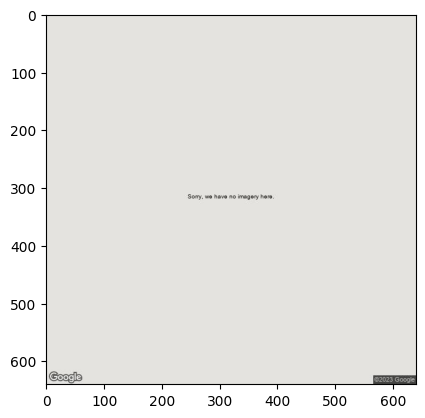

In [63]:
print(city[0])
plt.imshow(image[0])

LosAngeles


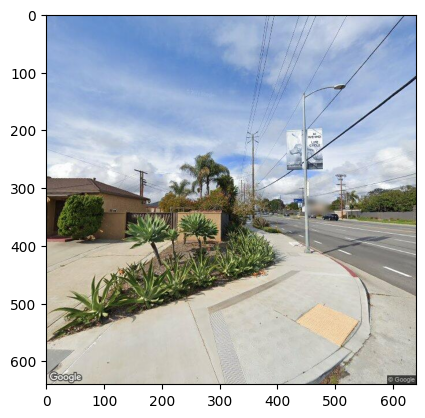

In [64]:
print(city[1])
plt.imshow(image[1])

Austin
30.215738165820955,-97.78244711986011


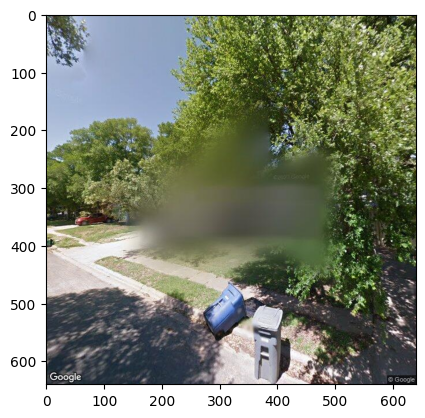

In [85]:
print(city[2])
print("{},{}".format(long[2], lat[2]))
plt.imshow(image[2])
